#Imports & Path

In [2]:
import os, sys
sys.path.append(os.path.abspath(".."))

import pandas as pd

from src.data_loader import MarketDataConfig, fetch_prices, compute_returns
from src.portfolio import Portfolio, portfolio_returns
from src.var_models import historical_var, parametric_var_normal
from src.backtest import var_exceptions, exception_summary
from src.plots import plot_var_overlay


#Config & Data

In [3]:
cfg = MarketDataConfig(
    tickers=["SPY", "TLT", "GLD", "UUP"],
    start="2015-01-01",
    use_log_returns=True
)

prices = fetch_prices(cfg)
rets = compute_returns(prices, use_log=cfg.use_log_returns)

prices.tail(), rets.tail()


(Ticker             GLD         SPY        TLT    UUP
 Date                                                
 2026-02-11  467.630005  691.960022  88.059998  26.83
 2026-02-12  451.390015  681.270020  89.230003  26.82
 2026-02-13  462.619995  681.750000  89.720001  26.82
 2026-02-17  448.200012  682.849976  89.870003  26.91
 2026-02-18  458.279999  686.289978  89.529999  27.08,
 Ticker           GLD       SPY       TLT       UUP
 Date                                              
 2026-02-11  0.011247 -0.000231 -0.005323  0.001119
 2026-02-12 -0.035346 -0.015569  0.013199 -0.000373
 2026-02-13  0.024574  0.000704  0.005476  0.000000
 2026-02-17 -0.031666  0.001612  0.001670  0.003350
 2026-02-18  0.022241  0.005025 -0.003790  0.006297)

#Portfolio

In [4]:
port = Portfolio(weights={"SPY": 0.4, "TLT": 0.3, "GLD": 0.2, "UUP": 0.1})
pret = portfolio_returns(rets, port)

pret.describe()


count    2797.000000
mean        0.000303
std         0.005438
min        -0.045451
25%        -0.002396
50%         0.000622
75%         0.003173
max         0.049112
Name: portfolio_return, dtype: float64

#VaR Models

In [5]:
WINDOW = 250

var95_hist = historical_var(pret, window=WINDOW, alpha=0.05)
var99_hist = historical_var(pret, window=WINDOW, alpha=0.01)

var95_param = parametric_var_normal(pret, window=WINDOW, alpha=0.05, use_mean=True)
var99_param = parametric_var_normal(pret, window=WINDOW, alpha=0.01, use_mean=True)

pd.concat([pret, var95_hist, var95_param], axis=1).dropna().head()


,portfolio_return,portfolio_return,portfolio_return
Date,,,
2015-12-30,-0.004677,-0.007535,-0.007564
2015-12-31,-0.002088,-0.007535,-0.007578
2016-01-04,-0.000519,-0.007535,-0.007584
2016-01-05,0.000608,-0.007535,-0.007586
2016-01-06,0.001534,-0.007535,-0.007587


#Backtest Summaries

In [6]:
b95 = var_exceptions(pret, var95_hist)
b99 = var_exceptions(pret, var99_hist)

sum95 = exception_summary(b95, alpha=0.05)
sum99 = exception_summary(b99, alpha=0.01)

pd.DataFrame([sum95, sum99], index=["VaR95", "VaR99"])


,n_obs,alpha,breaches,expected_breaches,breach_rate
VaR95,2548,0.05,128,127.40,0.050235
VaR99,2548,0.01,33,25.48,0.012951


#Plots

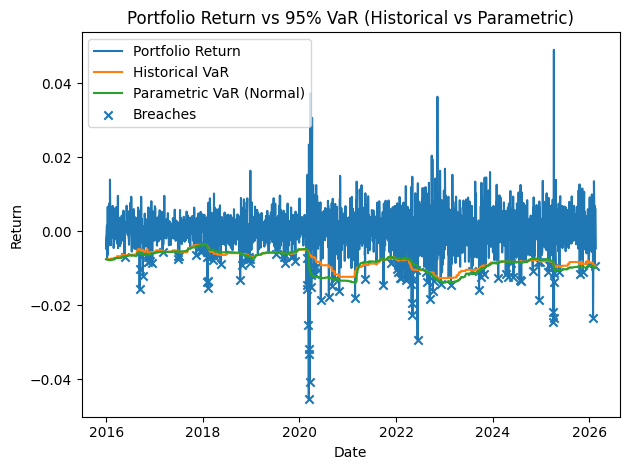

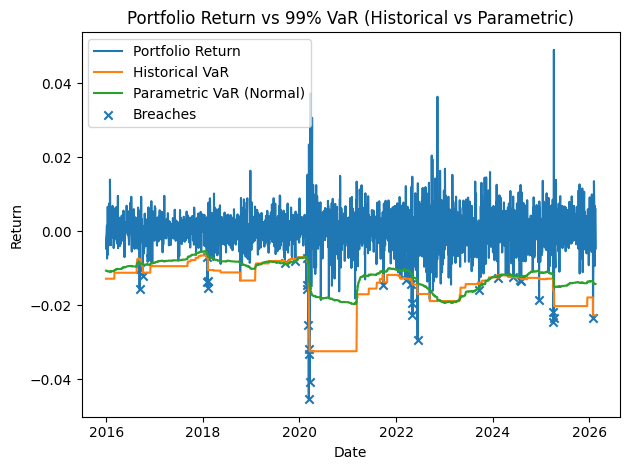

In [10]:
plot_var_overlay(
    returns=pret,
    var_hist=var95_hist,
    var_param=var95_param,
    title="Portfolio Return vs 95% VaR (Historical vs Parametric)",
    outpath="../outputs/figures/var_95_overlay.png",
)
plot_var_overlay(
    returns=pret,
    var_hist=var99_hist,
    var_param=var99_param,
    title="Portfolio Return vs 99% VaR (Historical vs Parametric)",
    outpath="../outputs/figures/var_99_overlay.png",
)


#Pre-Trade Impact (Simple)

In [ ]:
port_new = Portfolio(weights={"SPY": 0.6, "TLT": 0.2, "GLD": 0.1, "UUP": 0.1})

pret_new = portfolio_returns(rets, port_new)

var95_hist_new = historical_var(pret_new, window=WINDOW, alpha=0.05)
var95_param_new = parametric_var_normal(pret_new, window=WINDOW, alpha=0.05, use_mean=True)
var99_hist_new = historical_var(pret_new, window=WINDOW, alpha=0.01)
var99_param_new = parametric_var_normal(pret_new, window=WINDOW, alpha=0.01, use_mean=True)

comparison = pd.DataFrame({
    "VaR95_hist_old": var95_hist.dropna(),
    "VaR95_hist_new": var95_hist_new.dropna(),
    "VaR95_param_old": var95_param.dropna(),
    "VaR95_param_new": var95_param_new.dropna(),
    "VaR99_hist_old": var99_hist.dropna(),
    "VaR99_hist_new": var99_hist_new.dropna(),
    "VaR99_param_old": var99_param.dropna(),
    "VaR99_param_new": var99_param_new.dropna(),
}).dropna()

comparison.tail()


,VaR99_hist_old,VaR99_hist_new,VaR99_param_old,VaR99_param_new
Date,,,,
2026-02-11,-0.022723,-0.023997,-0.014140,-0.017530
2026-02-12,-0.022723,-0.023997,-0.014225,-0.017630
2026-02-13,-0.022723,-0.023997,-0.014215,-0.017617
2026-02-17,-0.022723,-0.023997,-0.014261,-0.017631
2026-02-18,-0.022723,-0.023997,-0.014263,-0.017629


#Summary of Pre-Trade Change

In [9]:
latest = comparison.iloc[-1]
(latest, (latest["VaR95_hist_new"] - latest["VaR95_hist_old"]), (latest["VaR95_param_new"] - latest["VaR95_param_old"]))


(VaR95_hist_old    -0.009317
 VaR95_hist_new    -0.011162
 VaR95_param_old   -0.009887
 VaR95_param_new   -0.012306
 Name: 2026-02-18 00:00:00, dtype: float64,
 np.float64(-0.001844989267319989),
 np.float64(-0.002419217192494617))